In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import MySQLdb

In [2]:
db = MySQLdb.connect(host="localhost", user="root", passwd="root", db="agbtables")
cursor = db.cursor()

In [3]:
def clean_me(df):
    """
    Returns a dataframe for the sample where
    objects are within faint and saturation limits.
    We also cut on:
        Contamination & Confusion flags
        Number of 2MASS matches (limited to 1 and only 1)
        Signal to Noise ratios (> 3 for WISE bands)
        Extended source flags (<= 2)
        
    Adds columns for the following colors:
        coljh: J-H
        colhk: H-K
        coljk: J-K
        col12: W1-W2
        col23: W2-W3
        col34: W3-W4
        col13: W1-W3
    """
    fntlims = [16.83,15.6,11.32,8.0,16.5,16.0,15.5] ## W1-4, J, H, K
    brtlims = [2.0,1.5,-3.0,-4.0] ## W1-4
    
    df.glon[df.glon > 180] = df.glon[df.glon > 180] - 360
    
    cut = (df.ccflag == "0000") & (df.n2mass == 1) & (df.w1snr > 1) & (df.w2snr > 1) & (df.w3snr > 1) & (df.w4snr > 1) & (df.extflg <= 2) & (df.match_rad <= 3)

    df["coljh"] = df.jmag - df.hmag
    df["colhk"] = df.hmag - df.kmag
    df["coljk"] = df.jmag - df.kmag
    df["col12"] = df.w1 - df.w2
    df["col23"] = df.w2 - df.w3
    df["col34"] = df.w3 - df.w4
    df["col13"] = df.w1 - df.w3

    return df[cut]

In [4]:
def plot_hist(df, column, bins, color, xtitle, figsize=None, plot_text=False):
    """
    This function serves to plot a line distribution of any
    quantity in the dataframe, provided the column, bins,
    color, and axis title are given.
    """
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(6,4))
        
    H, edges = np.histogram(df[column], bins=bins)
    ax = plt.subplot(111)
    ax.plot(edges[:-1], H, color=color)
    if plot_text:
        ax.text(0.1,0.9,plot_text,horizontalalignment="left",transform=ax.transAxes)
    ax.minorticks_on()
    ax.set_xlabel(xtitle)
    ax.set_ylabel("N Objects")
    plt.show()

In [5]:
def make_line(start, end):
    """ Returns x and y coordinates of an infinite 
    line given two points"""
    x0, y0 = start
    x1, y1 = end
    m = (y1-y0)/(x1-x0)
    b = y1 - m*x1
    xvals = np.linspace(-50,50, 10)
    yvals = m*xvals + b
    print "m: %f" % m
    print "b: %f\n" % b
    
    return xvals, yvals
    

In [6]:
def position_scatter(df, type_col, figsize=None):
    """
    Coes a galactic latitude-longitude scatter plot for 
    specified types, up to 5.
    """
    colors = ["b","r","g","y","purple"]
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(6,4))
        
    stypes = np.sort(list(set(df[type_col])))
    ax = plt.subplot(111)
    
    for ii in range(len(stypes)):
        ax.scatter(df["glon"][df[type_col] == stypes[ii]], df["glat"][df[type_col] == stypes[ii]], s=5, edgecolor="None", c=colors[ii])
    
    ax.set_ylim(-40,-28)
    ax.set_xlim(-85,-75)
    
    plt.show()

In [7]:
def mag_distributions(df, bins, type_col, cuts=None, figsize=None, ymax=None):
    """
    gives distributions of magnitudes for 2MASS and WISE mags for all
    pre-classified species. 
    
    If cuts are specified, pre-classed species are ignored.
    """
    fntlims = [16.83,15.6,11.32,8.0,16.5,16.0,15.5] ## W1-4, J, H, K
    brtlims = [2.0,1.5,-3.0,-4.0] ## W1-4

    colors = ["b","r","g","y","purple","orange"]
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(6,4))
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0, hspace=0)
    
    stypes = np.sort(list(set(df[type_col])))
    
    # 2MASS J
    ax = plt.subplot(331)
    H, edges = np.histogram(df.jmag, bins=bins)
    ax.plot(edges[:-1], H, color="k")
        
    if cuts:
        for ii in range(len(cuts)):
            H, edges = np.histogram(df["jmag"][cuts[ii]], bins=bins)
            name = "Cut %i" % (ii+1)
            ax.plot(edges[:-1], H, color=colors[ii], label=name)
        
    else:
        for ii in range(len(stypes)):
            H, edges = np.histogram(df["jmag"][df[type_col] == stypes[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])

    ax.plot([fntlims[4],fntlims[4]], [0,1100], color="gray", linestyle="--")
    ax.text(0.1,0.9,"2MASS J",horizontalalignment="left",transform=ax.transAxes)
    ax.legend(loc="lower left")
    plt.setp( ax.get_xticklabels(), visible=False)
    ax.minorticks_on()
    if ymax:
        ax.set_ylim(0,ymax)
    else:
        ax.set_ylim(0,1100)
    ax.set_xlim(edges[0],edges[-1])    

    # 2MASS H
    ax = plt.subplot(332)
    H, edges = np.histogram(df.hmag, bins=bins)
    ax.plot(edges[:-1], H, color="k")
    if cuts:
        for ii in range(len(cuts)):
            H, edges = np.histogram(df["hmag"][cuts[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
        
    else:
        for ii in range(len(stypes)):
            H, edges = np.histogram(df["hmag"][df[type_col] == stypes[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])

    ax.plot([fntlims[5],fntlims[5]], [0,1100], color="gray", linestyle="--")
    ax.text(0.1,0.9,"2MASS H",horizontalalignment="left",transform=ax.transAxes)
    plt.setp( ax.get_xticklabels(), visible=False)
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.minorticks_on()
    if ymax:
        ax.set_ylim(0,ymax)
    else:
        ax.set_ylim(0,1100)
    ax.set_xlim(edges[0],edges[-1])    

    # 2MASS K
    ax = plt.subplot(333)
    H, edges = np.histogram(df.kmag, bins=bins)
    ax.plot(edges[:-1], H, color="k")
    if cuts:
        for ii in range(len(cuts)):
            H, edges = np.histogram(df["kmag"][cuts[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
        
    else:
        for ii in range(len(stypes)):
            H, edges = np.histogram(df["kmag"][df[type_col] == stypes[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
    ax.plot([fntlims[6],fntlims[6]], [0,1100], color="gray", linestyle="--")
    ax.text(0.1,0.9,"2MASS K",horizontalalignment="left",transform=ax.transAxes)
    plt.setp( ax.get_xticklabels(), visible=False)
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.minorticks_on()
    if ymax:
        ax.set_ylim(0,ymax)
    else:
        ax.set_ylim(0,1100)
    ax.set_xlim(edges[0],edges[-1])    

    # W1
    ax = plt.subplot(334)
    H, edges = np.histogram(df.w1, bins=bins)
    ax.plot(edges[:-1], H, color="k")
    if cuts:
        for ii in range(len(cuts)):
            H, edges = np.histogram(df["w1"][cuts[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
        
    else:
        for ii in range(len(stypes)):
            H, edges = np.histogram(df["w1"][df[type_col] == stypes[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
    ax.plot([fntlims[0],fntlims[0]], [0,1100], color="gray", linestyle="--")
    ax.plot([brtlims[0],brtlims[0]], [0,1100], color="gray", linestyle="--")
    ax.text(0.1,0.9,"W1",horizontalalignment="left",transform=ax.transAxes)
    plt.setp( ax.get_xticklabels(), visible=False)
    ax.minorticks_on()
    if ymax:
        ax.set_ylim(0,ymax)
    else:
        ax.set_ylim(0,1100)
    ax.set_ylabel("N Objects")
    ax.set_xlim(edges[0],edges[-1])    

    # W2
    ax = plt.subplot(335)
    H, edges = np.histogram(df.w2, bins=bins)
    ax.plot(edges[:-1], H, color="k")
    if cuts:
        for ii in range(len(cuts)):
            H, edges = np.histogram(df["w2"][cuts[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
        
    else:
        for ii in range(len(stypes)):
            H, edges = np.histogram(df["w2"][df[type_col] == stypes[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
    ax.plot([fntlims[1],fntlims[1]], [0,1100], color="gray", linestyle="--")
    ax.plot([brtlims[1],brtlims[1]], [0,1100], color="gray", linestyle="--")
    ax.text(0.1,0.9,"W2",horizontalalignment="left",transform=ax.transAxes)
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.minorticks_on()
    if ymax:
        ax.set_ylim(0,ymax)
    else:
        ax.set_ylim(0,1100)
    ax.set_xlim(edges[0],edges[-1])    

    # W3
    ax = plt.subplot(336)
    H, edges = np.histogram(df.w3, bins=bins)
    ax.plot(edges[:-1], H, color="k")
    if cuts:
        for ii in range(len(cuts)):
            H, edges = np.histogram(df["w3"][cuts[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
        
    else:
        for ii in range(len(stypes)):
            H, edges = np.histogram(df["w3"][df[type_col] == stypes[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
    ax.plot([fntlims[2],fntlims[2]], [0,1100], color="gray", linestyle="--")
    ax.plot([brtlims[2],brtlims[2]], [0,1100], color="gray", linestyle="--")
    ax.text(0.1,0.9,"W3",horizontalalignment="left",transform=ax.transAxes)
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.minorticks_on()
    if ymax:
        ax.set_ylim(0,ymax)
    else:
        ax.set_ylim(0,1100)
    ax.set_xlim(edges[0],edges[-1])    

    # W4
    ax = plt.subplot(337)
    H, edges = np.histogram(df.w4, bins=bins)
    ax.plot(edges[:-1], H, color="k")
    if cuts:
        for ii in range(len(cuts)):
            H, edges = np.histogram(df["w4"][cuts[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
        
    else:
        for ii in range(len(stypes)):
            H, edges = np.histogram(df["w4"][df[type_col] == stypes[ii]], bins=bins)
            ax.plot(edges[:-1], H, color=colors[ii])
    ax.plot([fntlims[3],fntlims[3]], [0,1100], color="gray", linestyle="--")
    ax.plot([brtlims[3],brtlims[3]], [0,1100], color="gray", linestyle="--")
    ax.text(0.1,0.9,"W4",horizontalalignment="left",transform=ax.transAxes)
    ax.minorticks_on()
    if ymax:
        ax.set_ylim(0,ymax)
    else:
        ax.set_ylim(0,1100)
    ax.set_xlim(edges[0],edges[-1])    

    plt.show()

### OGLE-specific

In [23]:
def ogle_period_mag(df, mag, ytitle, figsize=None, plot_text=True, cuts=None, lines=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(12,4))
    
    colors = ["b","r","g","y","purple","orange"]
    
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0)
      
    # OSARGs
    ax = plt.subplot(131)
    for ii in range(len(cuts)):
        ax.scatter(np.log10(df["p"][cuts[ii] & (df.type == "OSARG")]), df[mag][cuts[ii] & (df.type == "OSARG")], c=colors[ii], s=2, edgecolor="None")
    if lines:
        for line in lines:
            ax.plot(line[0], line[1], color='k')
    if plot_text:
        ax.text(0.1, 0.9, "OSARG", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    ax.set_xlabel("log$_{10}$(p)")
    ax.set_ylabel(ytitle)
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(15,7)

    # Miras
    ax = plt.subplot(132)
    for ii in range(len(cuts)):
        ax.scatter(np.log10(df["p"][cuts[ii] & (df.type == "Mira")]), df[mag][cuts[ii] & (df.type == "Mira")], c=colors[ii], s=2, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "Mira", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlabel("log$_{10}$(p)")
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(15,7)
    
    # SRVs
    ax = plt.subplot(133)
    for ii in range(len(cuts)):
        ax.scatter(np.log10(df["p"][cuts[ii] & (df.type == "SRV")]), df[mag][cuts[ii] & (df.type == "SRV")], c=colors[ii], s=2, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "SRV", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlabel("log$_{10}$(p)")
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(15,7)
    plt.show()

In [24]:
def ogle_color_mag(df, color, mag, xtitle, ytitle, xlim=None, figsize=None, plot_text=True, cuts=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(12,4))
    colors = ["b","r","g","y","purple","orange"]
        
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0)
        
    ax = plt.subplot(131)
    for ii in range(len(cuts)):
        ax.scatter(df[color][cuts[ii] & (df.type == "OSARG")], df[mag][cuts[ii] & (df.type == "OSARG")], c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "OSARG", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    if xlim:
        ax.set_xlim(xlim[0],xlim[1])
    else:
        ax.set_xlim(-1,4.0)
    ax.set_ylim(16,7)

    ax = plt.subplot(132)
    for ii in range(len(cuts)):
        ax.scatter(df[color][cuts[ii] & (df.type == "Mira")], df[mag][cuts[ii] & (df.type == "Mira")], c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "Mira", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlabel(xtitle)
    if xlim:
        ax.set_xlim(xlim[0],xlim[1])
    else:
        ax.set_xlim(-1,4.0)
    ax.set_ylim(16,7)
    
    ax = plt.subplot(133)
    for ii in range(len(cuts)):
        ax.scatter(df[color][cuts[ii] & (df.type == "SRV")], df[mag][cuts[ii] & (df.type == "SRV")], c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "SRV", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlabel(xtitle)
    if xlim:
        ax.set_xlim(xlim)
    else:
        ax.set_xlim(-1,4.0)
    ax.set_ylim(16,7)
    plt.show()

In [25]:
def ogle_color_color(df, color1, color2, xtitle, ytitle, figsize=None, plot_text=True, cuts=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(12,4))

    colors = ["b","r","g","y","purple","orange"]
    
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0)
        
    ax = plt.subplot(131)
    for ii in range(len(cuts)):
        ax.scatter(df[color1][cuts[ii] & (df.type == "OSARG")], df[color2][cuts[ii] & (df.type == "OSARG")], c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "OSARG", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    
    ax.set_xlim(-1,4.0)
    ax.set_ylim(-1,2.)

    ax = plt.subplot(132)
    for ii in range(len(cuts)):
        ax.scatter(df[color1][cuts[ii] & (df.type == "Mira")], df[color2][cuts[ii] & (df.type == "Mira")], c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "Mira", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlabel(xtitle)
    
    ax.set_xlim(-1,4.0)
    ax.set_ylim(-1,2.)
    
    ax = plt.subplot(133)
    for ii in range(len(cuts)):
        ax.scatter(df[color1][cuts[ii] & (df.type == "SRV")], df[color2][cuts[ii] & (df.type == "SRV")], c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "SRV", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlabel(xtitle)
    
    ax.set_xlim(-1,4.0)
    ax.set_ylim(-1,2.)
    plt.show()

### MACHO-specific

In [26]:
def macho_period_mag(df, figsize=None, plot_text=True, cuts=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(12,4))
        
    colors = ["b","r","g","y","purple"]
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0)
    
    stypes = np.sort(list(set(df.sequence)))
    
    ax = plt.subplot(331)
    ax.scatter(np.log10(df.p0), df.v, c='k', s=1, edgecolor="None")
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df["p0"][cuts[ii]]), df["v"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(np.log10(df[df.sequence == stypes[ii]].p0), df[df.sequence == stypes[ii]].v, c=colors[ii], s=1, edgecolor="None")

    if plot_text:
        ax.text(0.1, 0.9, "V", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    ax.set_ylabel("mag")
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(16,8)

    ax = plt.subplot(332)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df["p0"][cuts[ii]]), df["r"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(np.log10(df[df.sequence == stypes[ii]].p0), df[df.sequence == stypes[ii]].r, c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "R", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(16,8)

    ax = plt.subplot(333)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df["p0"][cuts[ii]]), df["jmag"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(np.log10(df[df.sequence == stypes[ii]].p0), df[df.sequence == stypes[ii]].jmag, c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "2MASS J", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(16,8)

    ax = plt.subplot(334)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df["p0"][cuts[ii]]), df["hmag"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(np.log10(df[df.sequence == stypes[ii]].p0), df[df.sequence == stypes[ii]].hmag, c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "2MASS H", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_ylabel("mag")
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(16,8)

    ax = plt.subplot(335)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df["p0"][cuts[ii]]), df["kmag"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(np.log10(df[df.sequence == stypes[ii]].p0), df[df.sequence == stypes[ii]].kmag, c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "2MASS K", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(16,8)

    ax = plt.subplot(336)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df["p0"][cuts[ii]]), df["w1"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(np.log10(df[df.sequence == stypes[ii]].p0), df[df.sequence == stypes[ii]].w1, c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "W1", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(16,8)

    ax = plt.subplot(337)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df["p0"][cuts[ii]]), df["w2"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(np.log10(df[df.sequence == stypes[ii]].p0), df[df.sequence == stypes[ii]].w2, c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "W2", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    ax.set_xlabel("log$_{10}$(p)")
    ax.set_ylabel("mag")
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(16,8)

    ax = plt.subplot(338)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df["p0"][cuts[ii]]), df["w3"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(np.log10(df[df.sequence == stypes[ii]].p0), df[df.sequence == stypes[ii]].w3, c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "W3", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    ax.set_xlabel("log$_{10}$(p)")
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(16,8)

    ax = plt.subplot(339)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df["p0"][cuts[ii]]), df["w4"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(np.log10(df[df.sequence == stypes[ii]].p0), df[df.sequence == stypes[ii]].w4, c=colors[ii], s=1, edgecolor="None")
    if plot_text:
        ax.text(0.1, 0.9, "W4", horizontalalignment="left", transform=ax.transAxes)
    ax.minorticks_on()
    ax.set_xlabel("log$_{10}$(p)")
    plt.setp( ax.get_yticklabels(), visible=False)
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(16,8)

    plt.show()

In [27]:
def macho_color_mag(df, figsize=None, cuts=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(4,4))
        
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
    colors = ["b","r","g","y","purple"]
    stypes = np.sort(list(set(df.sequence)))
        
    ax = plt.subplot(231)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(df["coljh"][cuts[ii]], df["jmag"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(stypes)):
            ax.scatter(df[df.sequence == stypes[ii]].coljh, df["jmag"][df.sequence == stypes[ii]], c=colors[ii], s=1, edgecolor="None")

    ax.minorticks_on()
    ax.set_xlabel("$J-H$")
    ax.set_ylabel("2MASS $J$")
   
    ax.set_xlim(-1,4.0)
    ax.set_ylim(14,10)

    ax = plt.subplot(232)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(df["colhk"][cuts[ii]], df["hmag"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")

    else:
        for ii in range(len(stypes)):
            ax.scatter(df[df.sequence == stypes[ii]].colhk, df["hmag"][df.sequence == stypes[ii]], c=colors[ii], s=1, edgecolor="None")

    ax.minorticks_on()
    ax.set_xlabel("$H-K$")
    ax.set_ylabel("2MASS $H$")
   
    ax.set_xlim(-1,4.0)
    ax.set_ylim(13,10)

    ax = plt.subplot(233)
    
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(df["coljk"][cuts[ii]], df["kmag"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(stypes)):
            ax.scatter(df[df.sequence == stypes[ii]].coljk, df["kmag"][df.sequence == stypes[ii]], c=colors[ii], s=1, edgecolor="None")

    ax.minorticks_on()
    ax.set_xlabel("$J-K$")
    ax.set_ylabel("2MASS $J$")
   
    ax.set_xlim(-1,4.0)
    ax.set_ylim(13,10)

    ax = plt.subplot(234)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(df["col12"][cuts[ii]], df["w1"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(stypes)):
            ax.scatter(df[df.sequence == stypes[ii]].col12, df["w1"][df.sequence == stypes[ii]], c=colors[ii], s=1, edgecolor="None")

    ax.minorticks_on()
    ax.set_xlabel("$W1-W2$")
    ax.set_ylabel("$W1$")
   
    ax.set_xlim(-1,4.0)
    ax.set_ylim(12,7)

    ax = plt.subplot(235)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(df["col23"][cuts[ii]], df["w2"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(stypes)):
            ax.scatter(df[df.sequence == stypes[ii]].col23, df["w2"][df.sequence == stypes[ii]], c=colors[ii], s=1, edgecolor="None")

    ax.minorticks_on()
    ax.set_xlabel("$W2-W3$")
    ax.set_ylabel("$W2$")
   
    ax.set_xlim(-1,4.0)
    ax.set_ylim(12,7)

    ax = plt.subplot(236)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(df["col34"][cuts[ii]], df["w3"][cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(stypes)):
            ax.scatter(df[df.sequence == stypes[ii]].col34, df["w3"][df.sequence == stypes[ii]], c=colors[ii], s=1, edgecolor="None")

    ax.minorticks_on()
    ax.set_xlabel("$W3-W4$")
    ax.set_ylabel("$W3$")
   
    ax.set_xlim(-1,4.0)
    ax.set_ylim(12,7)

    plt.show()

In [47]:
def macho_color_color(df, color1, color2, xtitle, ytitle, figsize=None, cuts=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(4,4))
        
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
    colors = ["b","r","g","y","purple"]
    seqs = np.sort(list(set(df.sequence)))
        
    ax = plt.subplot(111)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(df[color1][cuts[ii]], df[color2][cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(seqs)):
            ax.scatter(df[color1][df.sequence == seqs[ii]], df[color2][df.sequence == seqs[ii]], c=colors[ii], s=1, edgecolor="None")

    ax.minorticks_on()
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
   
    ax.set_xlim(-1,4.0)
    ax.set_ylim(-1,4.)

    plt.show()

### MACHO-OGLE matches

In [80]:
def both_period_magnitude(df, cuts=None, figsize=None, plot_text=True, ylims=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(4,4))

    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
    colors = ["b","r","g","y","purple", "orange"]
    seqs = np.sort(list(set(df.sequence)))
        
    ax = plt.subplot(221)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df.p[cuts[ii]]), df.V_mean[cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(seqs)):
            ax.scatter(np.log10(df.p[df.sequence == seqs[ii]]), df.V_mean[df.sequence == seqs[ii]], c=colors[ii], s=1, edgecolor="None")

    if plot_text:
        ax.text(0.1, 0.9, "OGLE V avg vs. OGLE period", horizontalalignment="left", transform=ax.transAxes)
        
    ax.minorticks_on()
    ax.set_xlabel("log$_{10}$(p)")
    ax.set_ylabel("OGLE V mag")
    ax.set_xlim(0.5,2.8)
    if ylims:
        ax.set_ylim(ylims[0], ylims[1])
    else:
        ax.set_ylim(24,14)

    ax = plt.subplot(222)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df.p0[cuts[ii]]), df.v[cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(seqs)):
            ax.scatter(np.log10(df.p0[df.sequence == seqs[ii]]), df.v[df.sequence == seqs[ii]], c=colors[ii], s=1, edgecolor="None")

    if plot_text:
        ax.text(0.1, 0.9, "MACHO v vs. MACHO period", horizontalalignment="left", transform=ax.transAxes)
        
    ax.minorticks_on()
    ax.set_xlabel("MACHO log$_{10}$(p0)")
    ax.set_ylabel("MACHO V mag")

    ax.set_xlim(0.5,2.8)
    if ylims:
        ax.set_ylim(ylims[0], ylims[1])
    else:
        ax.set_ylim(24,14)

                
    ax = plt.subplot(223)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df.p0[cuts[ii]]), df.V_mean[cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(seqs)):
            ax.scatter(np.log10(df.p0[df.sequence == seqs[ii]]), df.V_mean[df.sequence == seqs[ii]], c=colors[ii], s=1, edgecolor="None")

    if plot_text:
        ax.text(0.1, 0.9, "OGLE V avg vs. MACHO period", horizontalalignment="left", transform=ax.transAxes)
        
    ax.minorticks_on()
    ax.set_xlabel("MACHO log$_{10}$(p0)")
    ax.set_ylabel("OGLE V mag")
    ax.set_xlim(0.5,2.8)
    if ylims:
        ax.set_ylim(ylims[0], ylims[1])
    else:
        ax.set_ylim(24,14)

    ax = plt.subplot(224)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df.p[cuts[ii]]), df.v[cuts[ii]], c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(seqs)):
            ax.scatter(np.log10(df.p[df.sequence == seqs[ii]]), df.v[df.sequence == seqs[ii]], c=colors[ii], s=1, edgecolor="None")

    if plot_text:
        ax.text(0.1, 0.9, "MACHO v vs. OGLE period", horizontalalignment="left", transform=ax.transAxes)
        
    ax.minorticks_on()
    ax.set_xlabel("OGLE log$_{10}$(p)")
    ax.set_ylabel("MACHO V mag")
    ax.set_xlim(0.5,2.8)
    if ylims:
        ax.set_ylim(ylims[0], ylims[1])
    else:
        ax.set_ylim(24,14)

    plt.show()

In [107]:
def both_period_period(df, cuts=None, figsize=None, lims=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(4,4))

    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
    colors = ["b","r","g","y","purple", "orange"]
    seqs = np.sort(list(set(df.sequence)))
        
    ax = plt.subplot(111)
    if cuts:
        for ii in range(len(cuts)):
            ax.scatter(np.log10(df.p[cuts[ii]]), np.log10(df.p1[cuts[ii]]), c=colors[ii], s=2, edgecolor="None")
    else:
        for ii in range(len(seqs)):
            ax.scatter(np.log10(df.p[df.sequence == seqs[ii]]), np.log10(df.p1[df.sequence == seqs[ii]]), c=colors[ii], s=2, edgecolor="None")
       
    ax.minorticks_on()
    ax.set_xlabel("OGLE log$_{10}$(p)")
    ax.set_ylabel("MACHO log$_{10}$(p1)")
    if lims:
        ax.set_xlim(lims[0], lims[1])
        ax.set_ylim(lims[0], lims[1])
    else:
        ax.set_xlim(0.5, 2.8)
        ax.set_ylim(0.5, 2.8)
        
    plt.show()

## First: OGLE-III

In [30]:
sql = "SELECT * FROM ogle3_allwise_allmags WHERE field LIKE 'LMC%';"
ogle = pd.read_sql(sql, db)
ogle = clean_me(ogle)
ogle_c = ogle.spectr == "C-rich"
ogle_o = ogle.spectr == "O-rich"
ogle["W_I"] = ogle.I_mean - 1.55*(ogle.V_mean - ogle.I_mean)

In [129]:
# Define some sets of cuts so that I don't have to repeat myself
cuts1 = [ogle.col12 < 0.2, ogle.col12 > 0.2]
cuts2 = [ogle.coljk < 1.4, (ogle.coljk > 1.4) & (ogle.coljk < 2.0), ogle.coljk > 2.0]
cuts3 = [(ogle.W_I < (-5.45)*np.log10(ogle.p) +  18.73), (ogle.W_I > (-5.45)*np.log10(ogle.p) +  18.73) & (ogle.W_I < (-5.45)*np.log10(ogle.p) +  19.82), (ogle.W_I > (-5.45)*np.log10(ogle.p) +  19.82)]

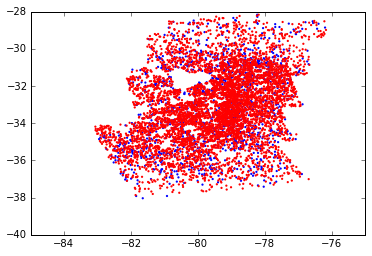

In [32]:
position_scatter(ogle, "spectr")

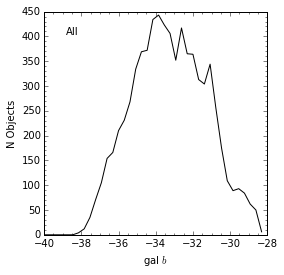

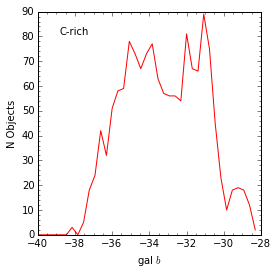

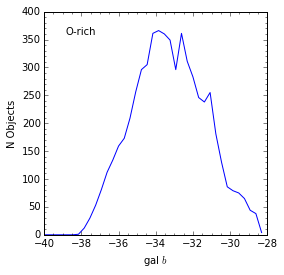

In [33]:
plot_hist(ogle, "glat", np.linspace(-40,-28,40.), 'k', "gal $b$", figsize=(4,4), plot_text="All")
plot_hist(ogle[ogle_c], "glat", np.linspace(-40,-28,40.), 'r', "gal $b$", figsize=(4,4), plot_text="C-rich")
plot_hist(ogle[ogle_o], "glat", np.linspace(-40,-28,40.), 'b', "gal $b$", figsize=(4,4), plot_text="O-rich")

There is significant contamination in OGLE sample from likely QSOs, which can be recognized by W3-W4 > 1 but also sufficiently rejected by W1-W2 < 0.3. If we necessitate W1-W2 > 0.3 we sufficiently select bonafide AGB stars. Given that we are looking towards the LMC, these AGB stars must be dominated by C-type AGB stars, and indeed in W1-W2 vs W2-W3 they do form the characteristic locus of C-stars.

Another takeaway: OGLE classifications are dead wrong and should not be used moving forward.

To Do: draw two straight lines in period luminosity to define AGB stars from contaminants. Split into 3 subsamples using absolute mag. Then replot in all diagrams (col-col, col-mag, etc). Then choose most impressive for paper. Want to demonstrate that OGLE is definitely incorrect.

Send info for paper where OGLE describes classifications

m: -5.454545
b: 17.909091

m: -5.454545
b: 18.727273

m: -5.454545
b: 19.818182

m: -5.454545
b: 21.181818



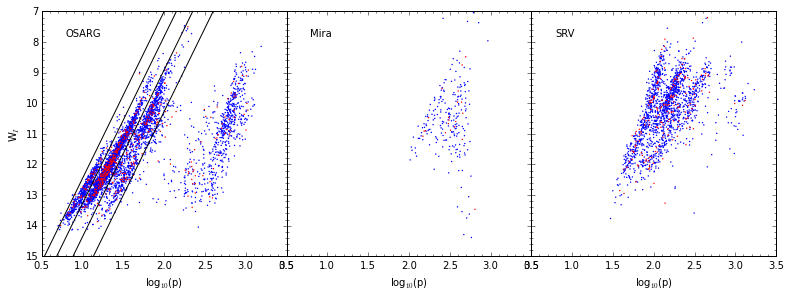

In [130]:
line0 = make_line([0.9,13.],[1.45,10.])
line1 = make_line([1.05,13.], [1.6,10.])
line2 = make_line([1.25,13.], [1.8,10.])
line3 = make_line([1.5,13.], [2.05,10.])

ogle_period_mag(ogle, "W_I", "W$_I$", figsize=(12,4), cuts=cuts1, lines=[line0, line1, line2, line3])
# plt.scatter(np.log10(ogle.p), ogle.hmag, s=1, edgecolor='None')

In [70]:
m = -5.454545
seq1 = (ogle.W_I > np.log10(ogle.p)*m + 17.909091) & (ogle.W_I < np.log10(ogle.p)*m + 18.727273)
seq2 = (ogle.W_I > np.log10(ogle.p)*m + 18.727273) & (ogle.W_I < np.log10(ogle.p)*m + 19.818182)
seq3 = (ogle.W_I > np.log10(ogle.p)*m + 19.818182) & (ogle.W_I < np.log10(ogle.p)*m + 21.181818)


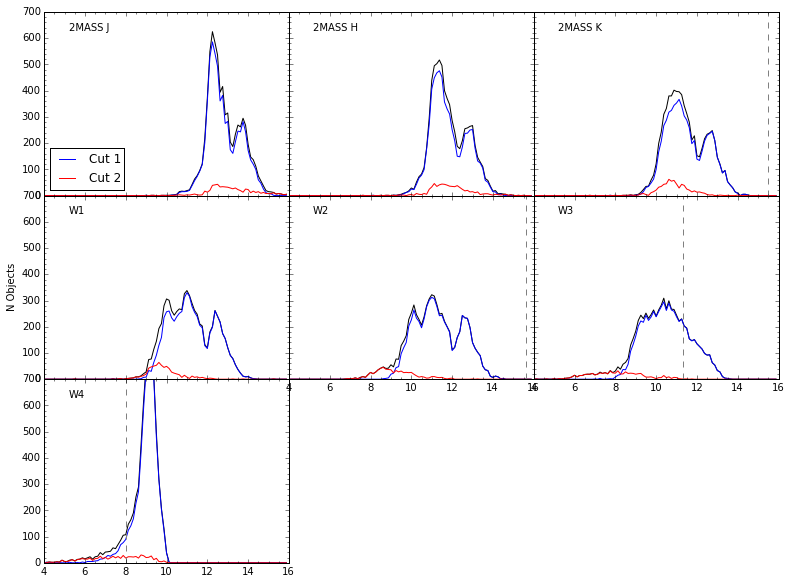

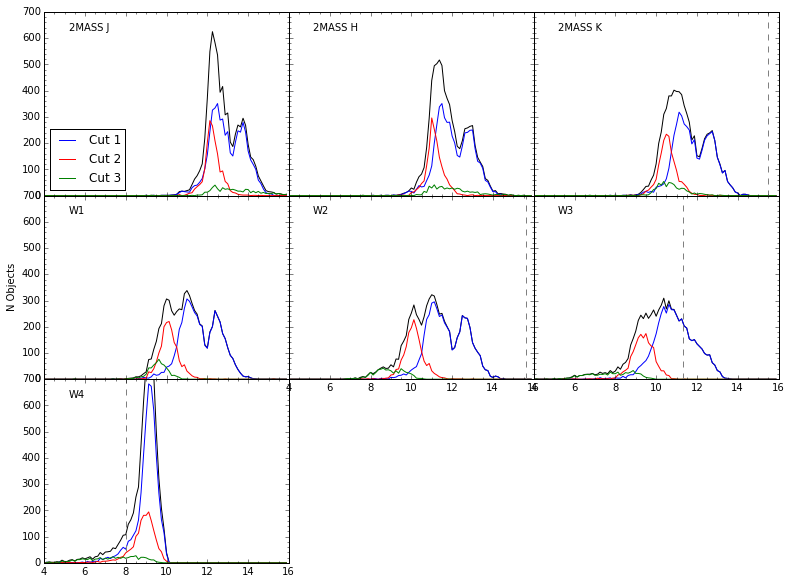

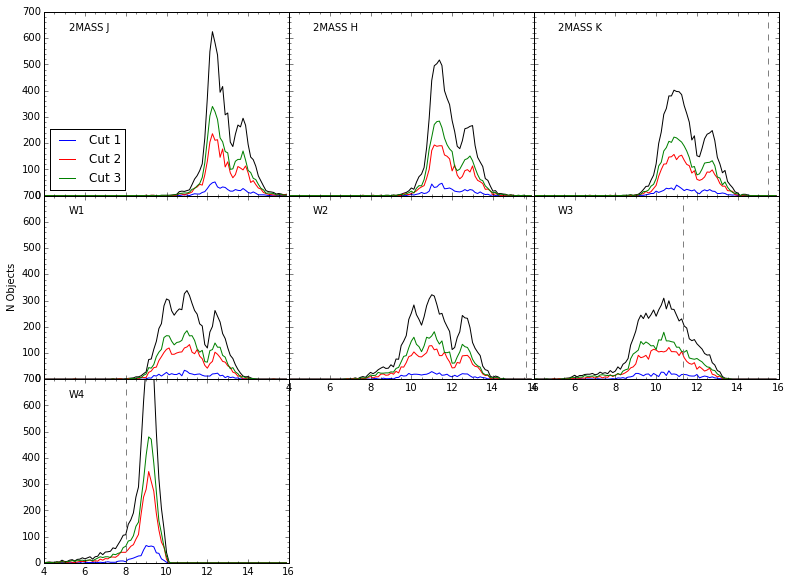

In [35]:
mag_distributions(ogle, type_col="spectr", bins = np.linspace(4,16,97), figsize=(12,9), cuts=cuts1, ymax=700)
mag_distributions(ogle, type_col="spectr", bins = np.linspace(4,16,97), figsize=(12,9), cuts=cuts2, ymax=700)
mag_distributions(ogle, type_col="spectr", bins = np.linspace(4,16,97), figsize=(12,9), cuts=cuts3, ymax=700)


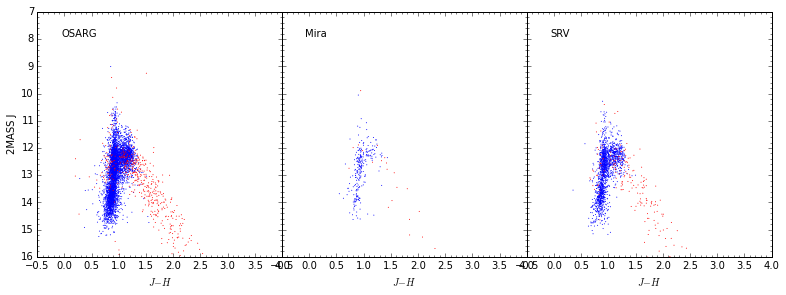

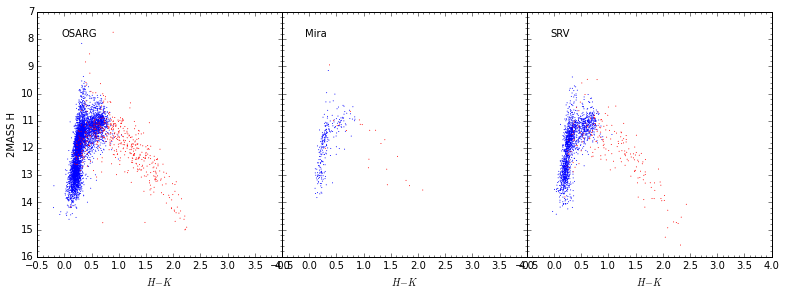

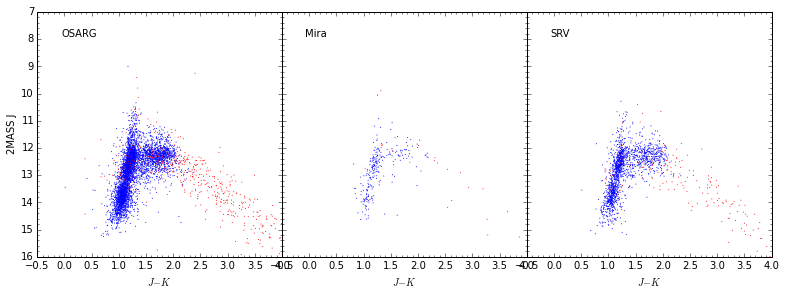

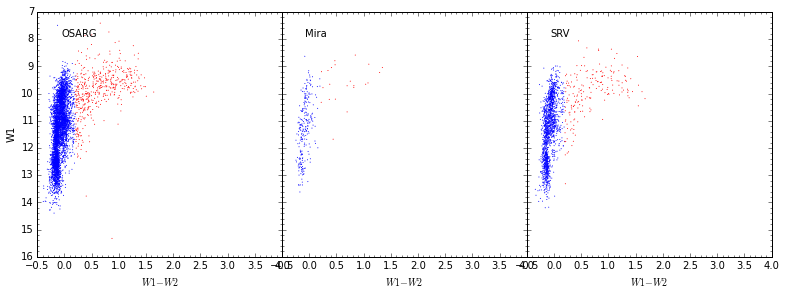

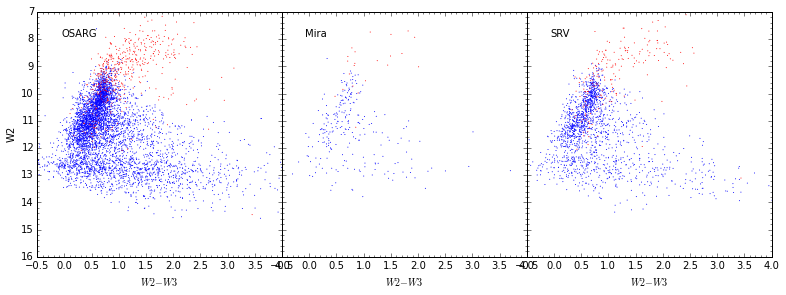

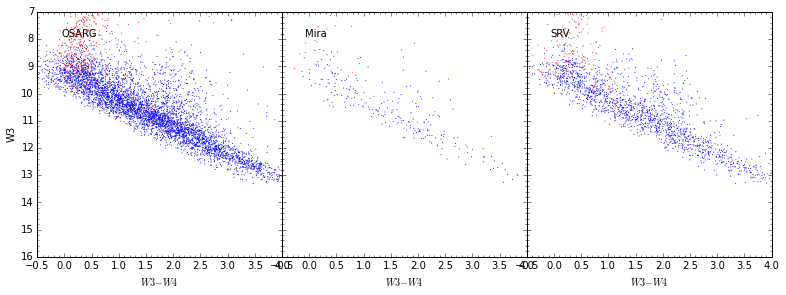

In [36]:
ogle_color_mag(ogle, "coljh", "jmag", "$J-H$", "2MASS J", xlim=(-0.5, 4), figsize=(12,4), cuts=cuts1)
ogle_color_mag(ogle, "colhk", "hmag", "$H-K$", "2MASS H", xlim=(-0.5, 4), figsize=(12,4), cuts=cuts1)
ogle_color_mag(ogle, "coljk", "jmag", "$J-K$", "2MASS J", xlim=(-0.5, 4), figsize=(12,4), cuts=cuts1)
ogle_color_mag(ogle, "col12", "w1", "$W1-W2$", "W1", xlim=(-0.5, 4) , figsize=(12,4), cuts=cuts1)
ogle_color_mag(ogle, "col23", "w2", "$W2-W3$", "W2", xlim=(-0.5, 4) , figsize=(12,4), cuts=cuts1)
ogle_color_mag(ogle, "col34", "w3", "$W3-W4$", "W3", xlim=(-0.5, 4) , figsize=(12,4), cuts=cuts1)

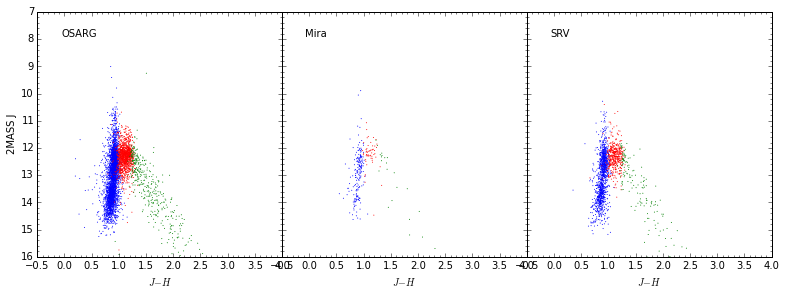

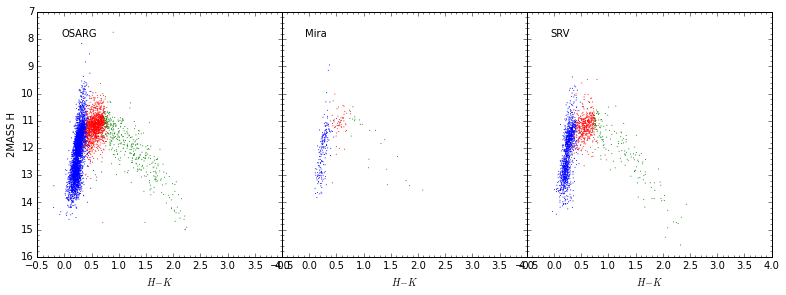

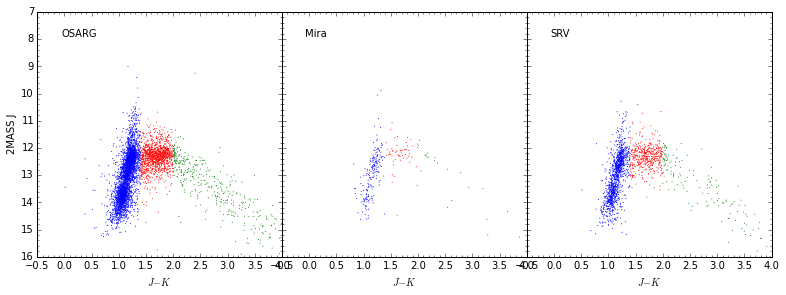

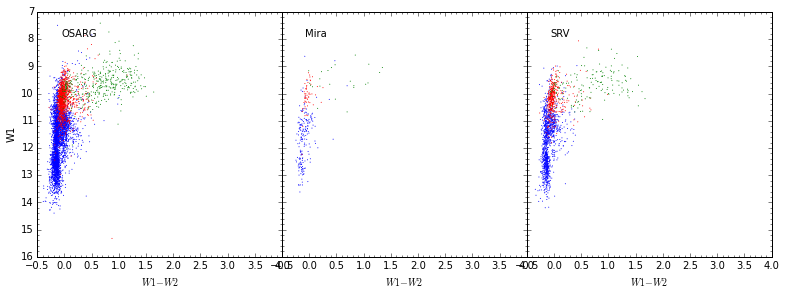

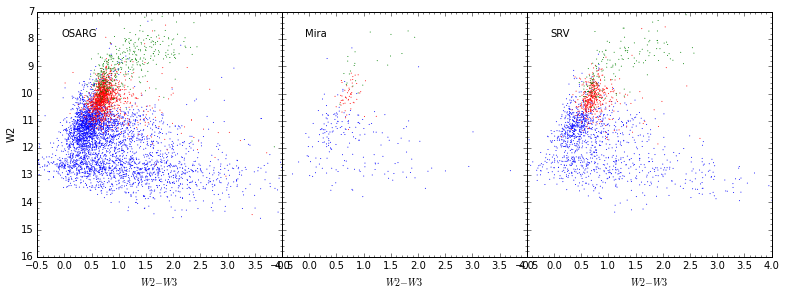

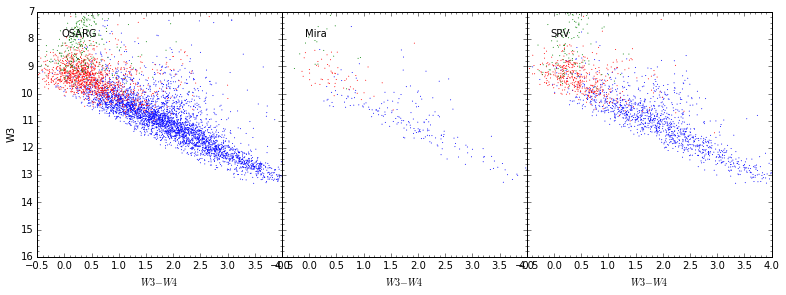

In [37]:
ogle_color_mag(ogle, "coljh", "jmag", "$J-H$", "2MASS J", xlim=(-0.5, 4), figsize=(12,4), cuts=cuts2)
ogle_color_mag(ogle, "colhk", "hmag", "$H-K$", "2MASS H", xlim=(-0.5, 4), figsize=(12,4), cuts=cuts2)
ogle_color_mag(ogle, "coljk", "jmag", "$J-K$", "2MASS J", xlim=(-0.5, 4), figsize=(12,4), cuts=cuts2)
ogle_color_mag(ogle, "col12", "w1", "$W1-W2$", "W1", xlim=(-0.5, 4) , figsize=(12,4), cuts=cuts2)
ogle_color_mag(ogle, "col23", "w2", "$W2-W3$", "W2", xlim=(-0.5, 4) , figsize=(12,4), cuts=cuts2)
ogle_color_mag(ogle, "col34", "w3", "$W3-W4$", "W3", xlim=(-0.5, 4) , figsize=(12,4), cuts=cuts2)

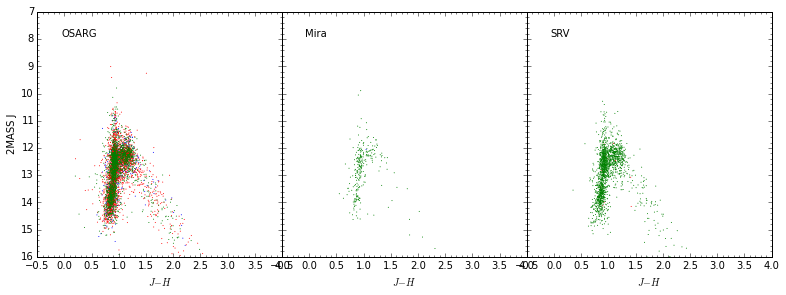

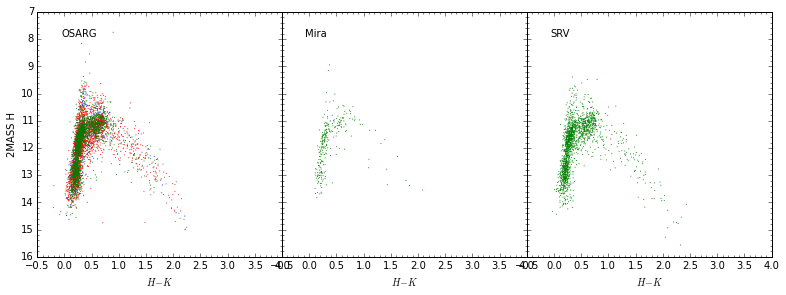

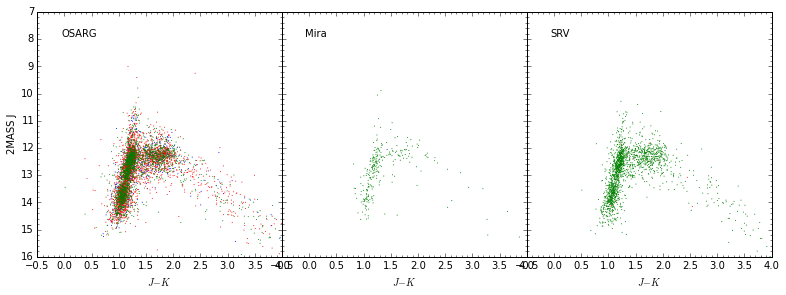

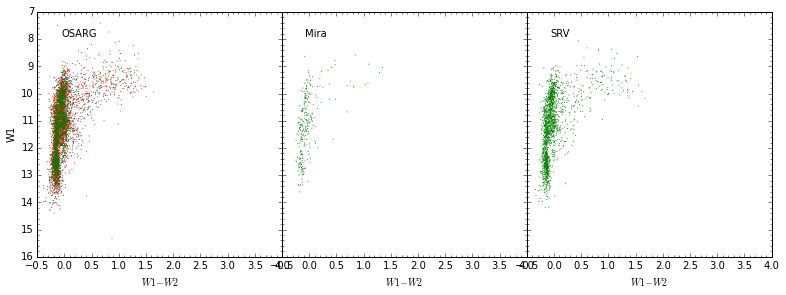

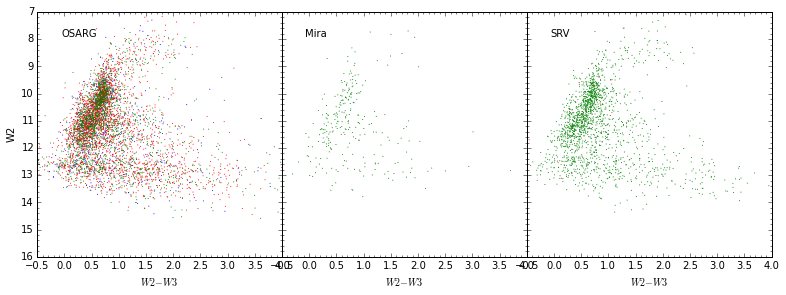

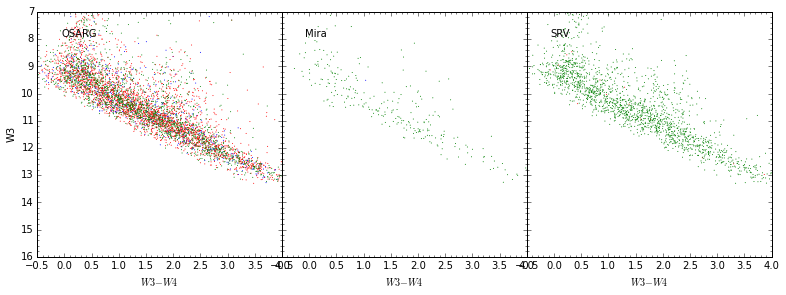

In [38]:
ogle_color_mag(ogle, "coljh", "jmag", "$J-H$", "2MASS J", xlim=(-0.5, 4), figsize=(12,4), cuts=cuts3)
ogle_color_mag(ogle, "colhk", "hmag", "$H-K$", "2MASS H", xlim=(-0.5, 4), figsize=(12,4), cuts=cuts3)
ogle_color_mag(ogle, "coljk", "jmag", "$J-K$", "2MASS J", xlim=(-0.5, 4), figsize=(12,4), cuts=cuts3)
ogle_color_mag(ogle, "col12", "w1", "$W1-W2$", "W1", xlim=(-0.5, 4) , figsize=(12,4), cuts=cuts3)
ogle_color_mag(ogle, "col23", "w2", "$W2-W3$", "W2", xlim=(-0.5, 4) , figsize=(12,4), cuts=cuts3)
ogle_color_mag(ogle, "col34", "w3", "$W3-W4$", "W3", xlim=(-0.5, 4) , figsize=(12,4), cuts=cuts3)

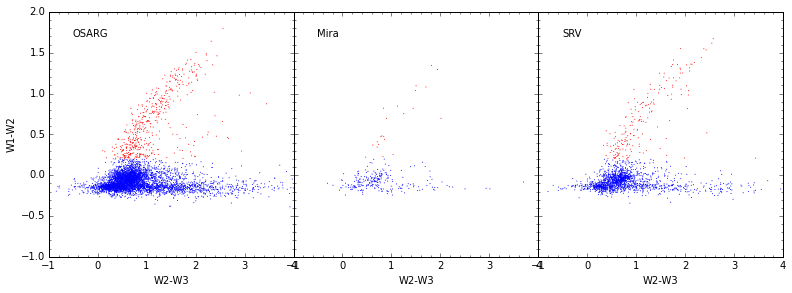

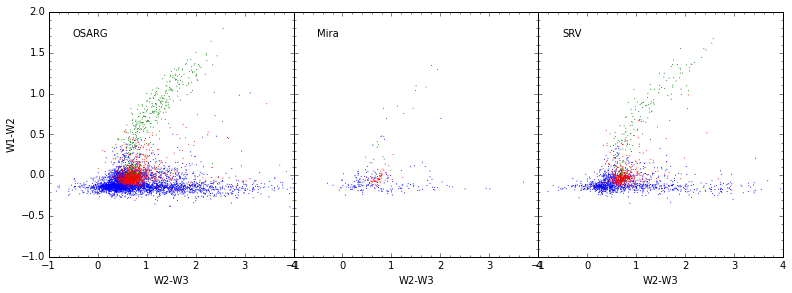

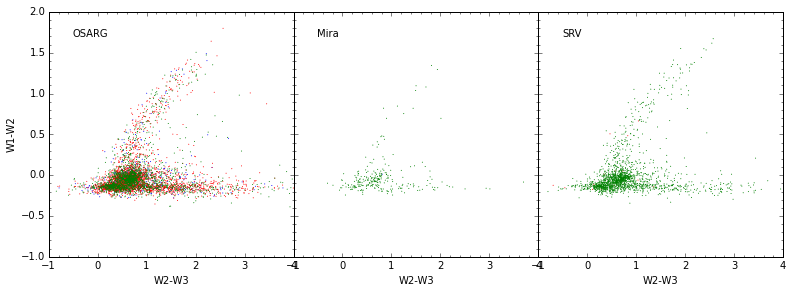

In [39]:
ogle_color_color(ogle, "col23", "col12", "W2-W3", "W1-W2", figsize=(12,4), cuts=cuts1)
ogle_color_color(ogle, "col23", "col12", "W2-W3", "W1-W2", figsize=(12,4), cuts=cuts2)
ogle_color_color(ogle, "col23", "col12", "W2-W3", "W1-W2", figsize=(12,4), cuts=cuts3)

Look up spectral classifications of OSARGs if they are available. They're peculiar. They seem to go everywhere but not have solid AGB colors

## Next Up: MACHO

In [134]:
sql = "SELECT * FROM macho_allwise_allmags WHERE gal_loc = 'BULGE';"
macho = pd.read_sql(sql, db)
macho = clean_me(macho)

(('BULGE',), ('gal_lo',), ('LMC',), ('SMC',))

In [135]:
# Define some sets of cuts so that I don't have to repeat myself
cuts1 = [macho.col12 < 0.2, macho.col12 > 0.2]
cuts2 = [macho.coljk < 1.4, (macho.coljk > 1.4) & (macho.coljk < 2.0), macho.coljk > 2.0]

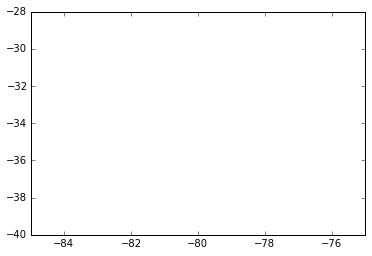

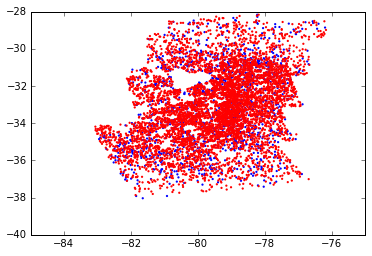

In [136]:
# position_scatter(macho, "sequence")
# position_scatter(ogle, "spectr")

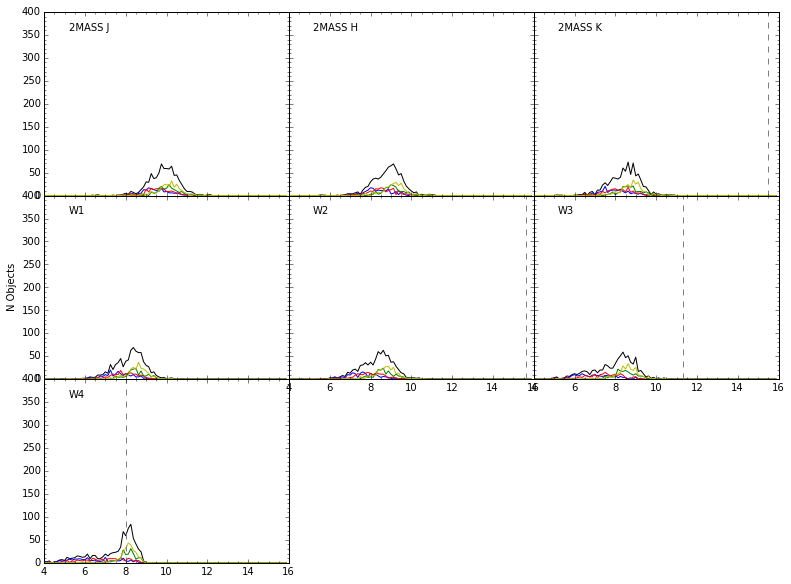

In [137]:
mag_distributions(macho, type_col="sequence", bins = np.linspace(4,16,97), figsize=(12,9), ymax=400)

Do all the same plots as OGLE for MACHO

Show matching fractions to WISE and to the common set as well as unmatched

Do all the same for MACHO in bulge

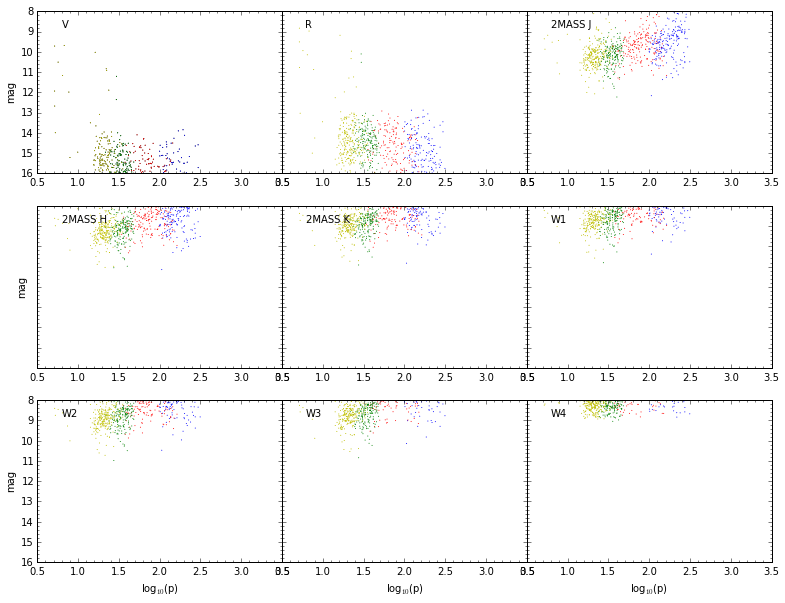

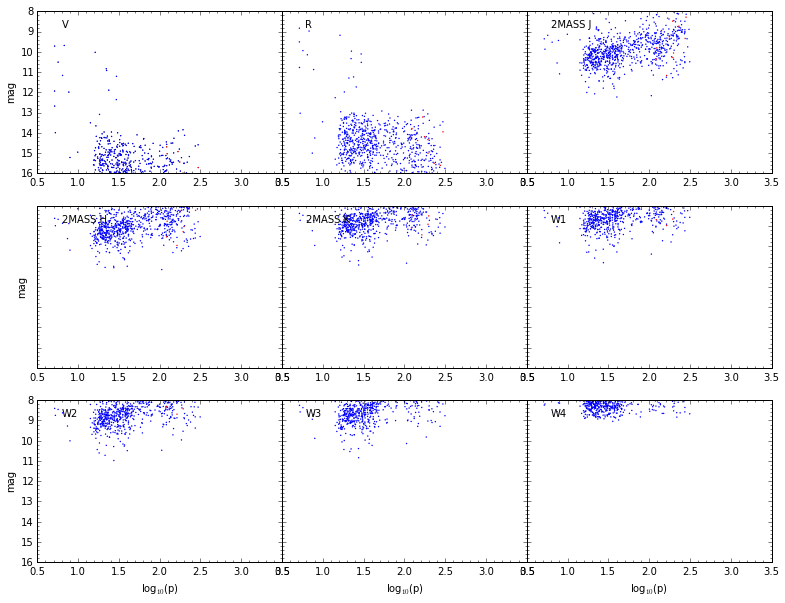

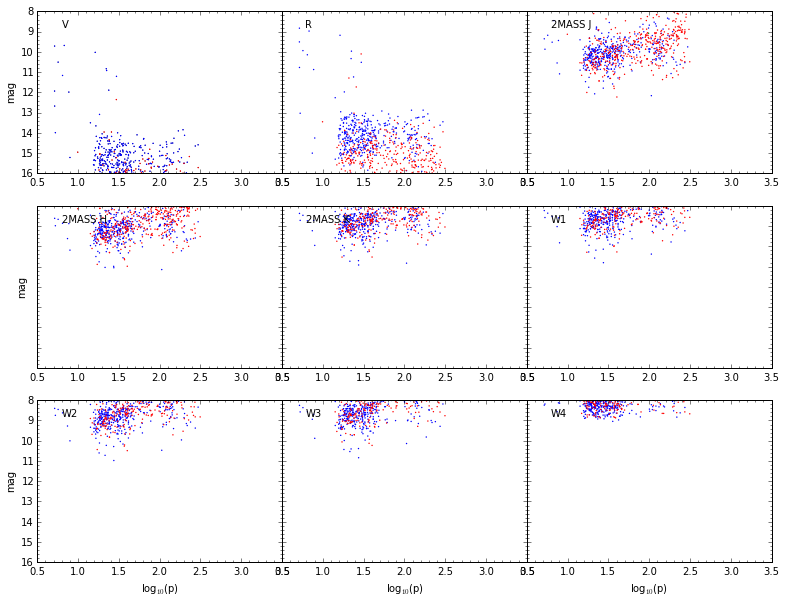

In [138]:
macho_period_mag(macho, figsize=(12,9))
macho_period_mag(macho, figsize=(12,9), cuts=cuts1)
macho_period_mag(macho, figsize=(12,9), cuts=cuts2)

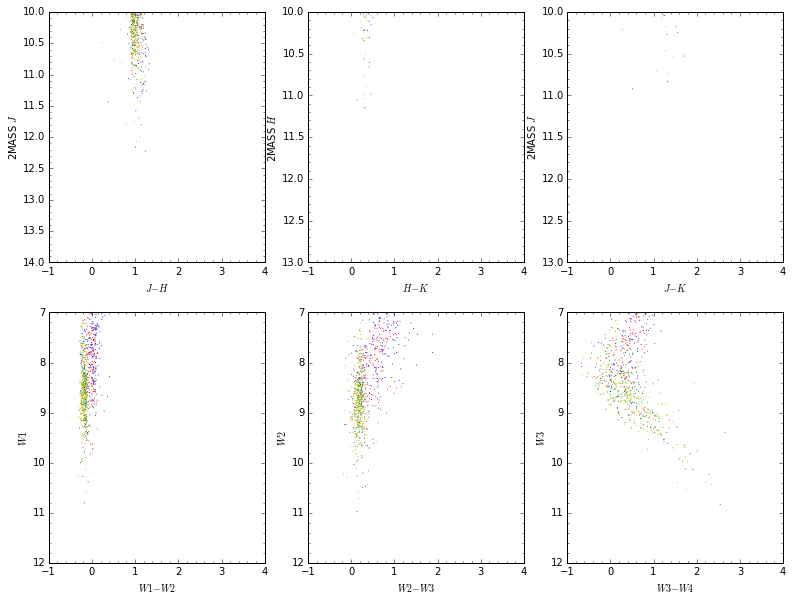

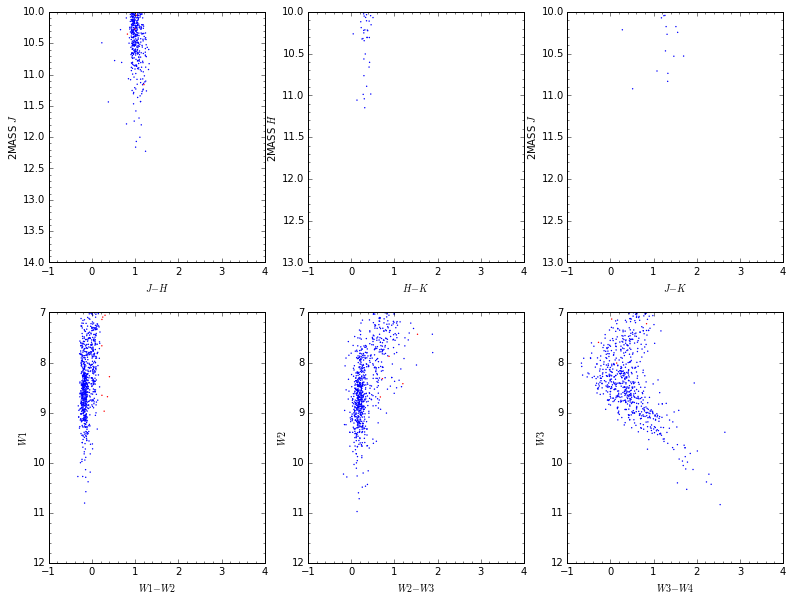

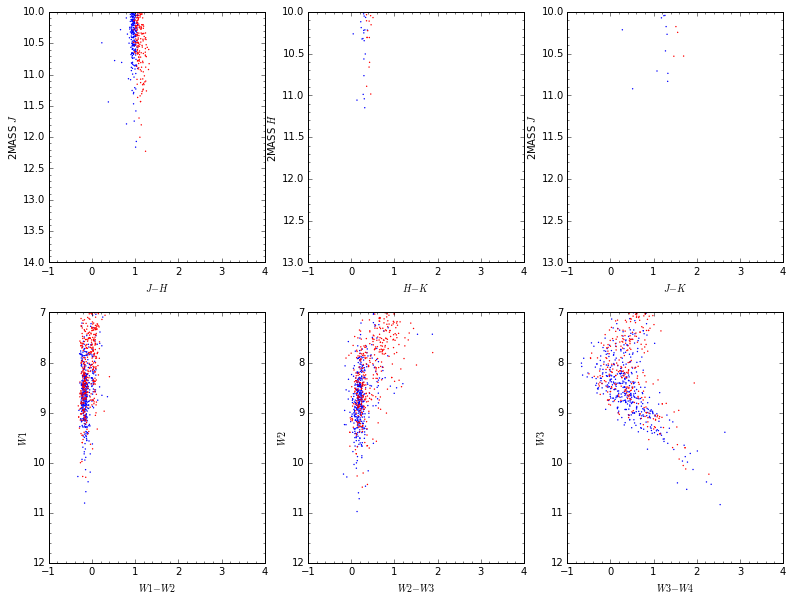

In [139]:
macho_color_mag(macho, figsize=(12,9))
macho_color_mag(macho, figsize=(12,9), cuts=cuts1)
macho_color_mag(macho, figsize=(12,9), cuts=cuts2)

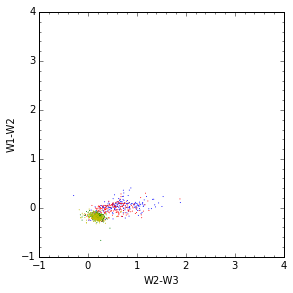

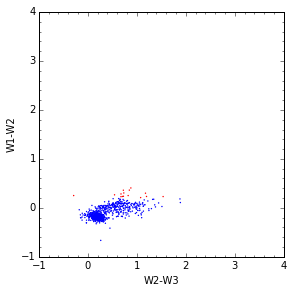

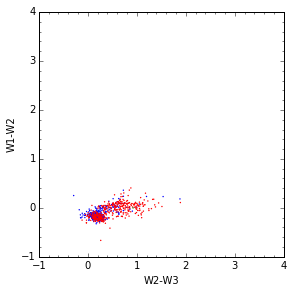

In [140]:
macho_color_color(macho, "col23", "col12", "W2-W3", "W1-W2")
macho_color_color(macho, "col23", "col12", "W2-W3", "W1-W2", cuts=cuts1)
macho_color_color(macho, "col23", "col12", "W2-W3", "W1-W2", cuts=cuts2)


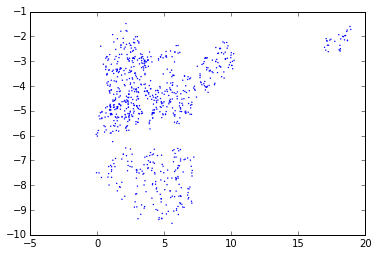

In [144]:
plt.scatter(macho.glon, macho.glat, s=2, edgecolor="None")
plt.show()

In [145]:
len(macho)

817

## Their intersection

In [49]:
colstring = "wisename	machoid	p0	p1	v	r	j	h	gal_loc	sequence	k	ogle3cnt	ogle3id	field	starid	type	evol	spectr	I_mean	V_mean	p	I_amp	match_rad	ra	decl	glon	glat	w1	w1err	w1snr	w2	w2err	w2snr	w3	w3err	w3snr	w4	w4err	w4snr	ccflag	extflg	var_flg	n2mass	jmag	jerr	hmag	herr	kmag	kerr".split()
both = pd.read_csv("../samples/ogle_macho_allwise_everything_nohead.dat", sep="\t", header=None, names=colstring)
both = clean_me(both)
both["W_I"] = both.I_mean - 1.55*(both.V_mean - both.I_mean)

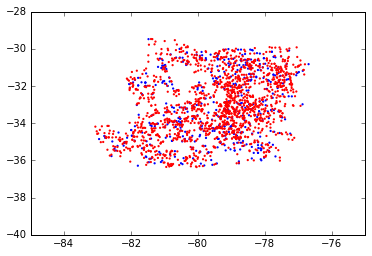

In [50]:
position_scatter(both, "spectr")

In [51]:
cursor.execute("SELECT COUNT(*) FROM ogle3_agbs WHERE field LIKE 'LMC%'")
ogle_init = int(cursor.fetchall()[0][0])
cursor.execute("SELECT COUNT(*) FROM ogle3_allwise_allmags WHERE field LIKE 'LMC%'")
ogle_matched = int(cursor.fetchall()[0][0])
cursor.execute("SELECT COUNT(*) FROM macho_lpvs WHERE gal_loc = 'LMC'")
macho_init = int(cursor.fetchall()[0][0])
cursor.execute("SELECT COUNT(*) FROM macho_allwise_allmags WHERE gal_loc = 'LMC'")
macho_matched = int(cursor.fetchall()[0][0])

print "OGLE original: %i" % ogle_init
print "OGLE matched to WISE: %i" % ogle_matched
print "OGLE matched and cleaned: %i" % len(ogle)
print "OGLE matched and cleaned fraction: %f\n" % (len(ogle)/float(ogle_init))

print "MACHO original: %i" % macho_init
print "MACHO matched to WISE: %i" % macho_matched
print "MACHO matched and cleaned: %i" % len(macho)
print "MACHO matched and cleaned fraction: %f\n" % (len(macho)/float(macho_init))

print "OGLE/MACHO intersection matched to WISE: %i" % len(both)
print "OGLE to OGLE/MACHO intersection fraction: %f" % (len(both)/float(ogle_init))
print "MACHO to OGLE/MACHO intersection fraction: %f" % (len(both)/float(macho_init))


OGLE original: 46182
OGLE matched to WISE: 43788
OGLE matched and cleaned: 7420
OGLE matched and cleaned fraction: 0.160669

MACHO original: 10248
MACHO matched to WISE: 10124
MACHO matched and cleaned: 2631
MACHO matched and cleaned fraction: 0.256733

OGLE/MACHO intersection matched to WISE: 2273
OGLE to OGLE/MACHO intersection fraction: 0.049218
MACHO to OGLE/MACHO intersection fraction: 0.221799


In [103]:
# Define some sets of cuts so that I don't have to repeat myself
cuts1 = [both.col12 < 0, both.col12 > 0]
cuts2 = [both.coljk < 1.4, (both.coljk > 1.4) & (both.coljk < 2.0), both.coljk > 2.0]

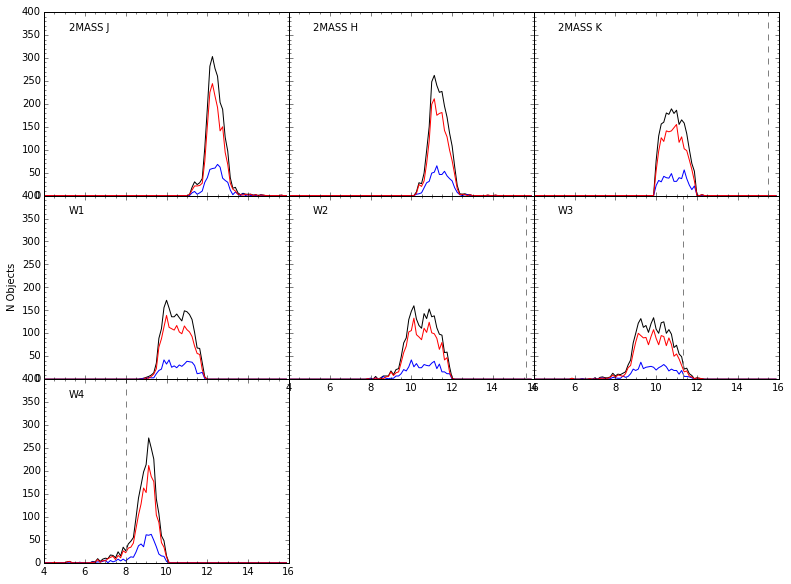

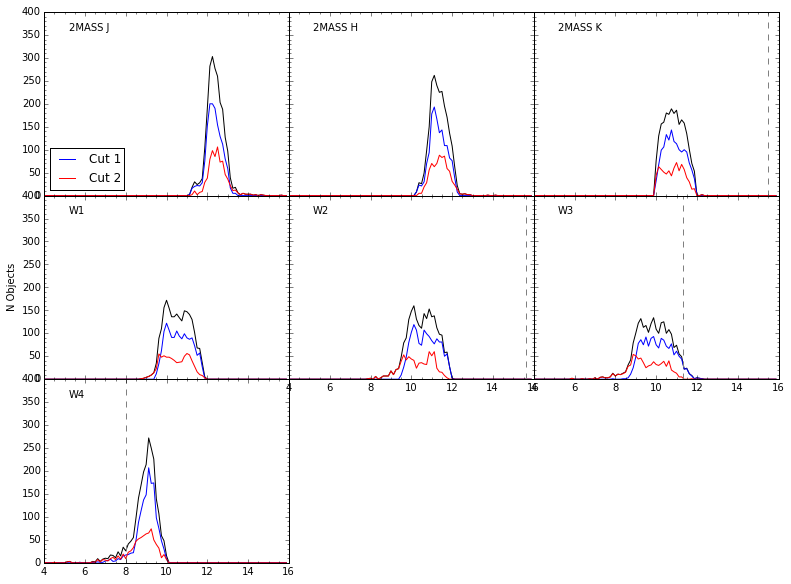

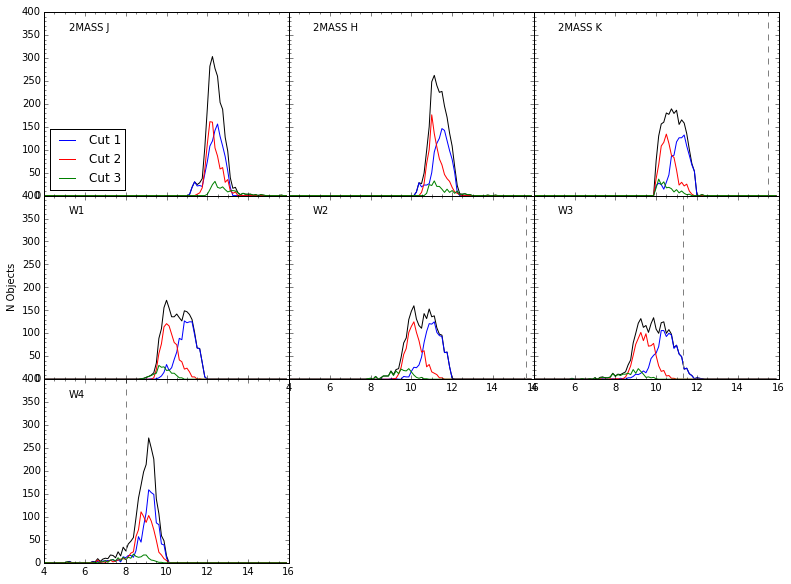

In [53]:
mag_distributions(both, type_col="spectr", bins = np.linspace(4,16,97), figsize=(12,9), ymax=400)
mag_distributions(both, type_col="spectr", bins = np.linspace(4,16,97), figsize=(12,9), ymax=400, cuts=cuts1)
mag_distributions(both, type_col="spectr", bins = np.linspace(4,16,97), figsize=(12,9), ymax=400, cuts=cuts2)


Are these sequences corresponding to each other or not? Is the period the same?

Define sequences in OGLE data and plot those sequences in MACHO data, then vice versa

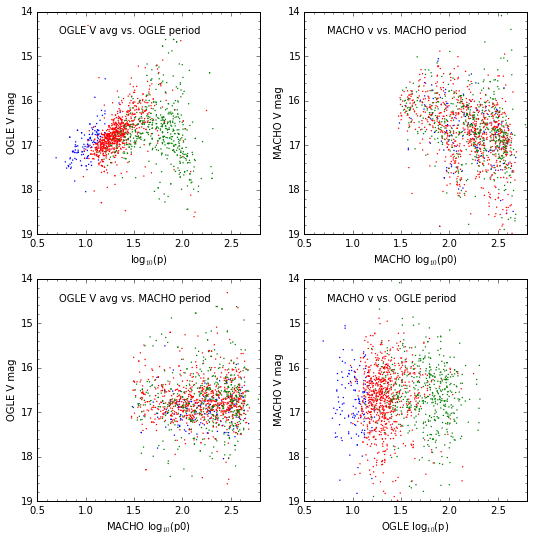

In [81]:
seq1 = (both.W_I > np.log10(both.p)*m + 17.909091) & (both.W_I < np.log10(both.p)*m + 18.727273)
seq2 = (both.W_I > np.log10(both.p)*m + 18.727273) & (both.W_I < np.log10(both.p)*m + 19.818182)
seq3 = (both.W_I > np.log10(both.p)*m + 19.818182) & (both.W_I < np.log10(both.p)*m + 21.181818)

both_period_magnitude(both, figsize=(8,8), ylims=[19, 14], cuts=[seq1, seq2, seq3])

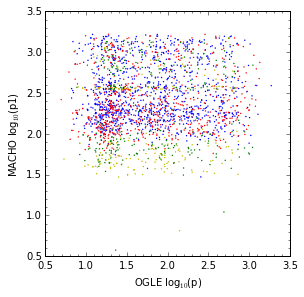

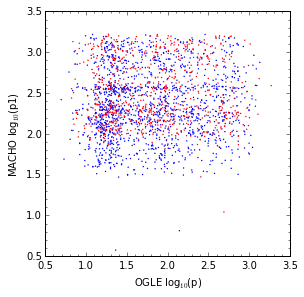

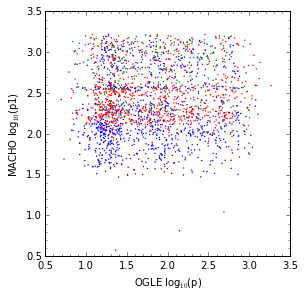

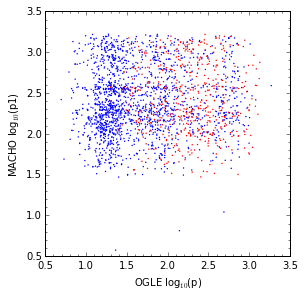

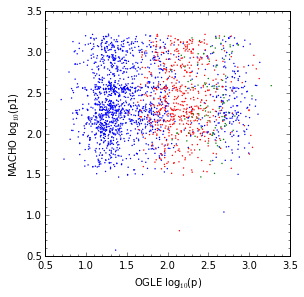

In [114]:
both_period_period(both, lims=[0.5,3.5], cuts=[both.sequence == 'seq1',both.sequence == 'seq2',both.sequence == 'seq3',both.sequence == 'seq4'])
both_period_period(both, lims=[0.5,3.5], cuts=cuts1)
both_period_period(both, lims=[0.5,3.5], cuts=cuts2)
both_period_period(both, lims=[0.5,3.5], cuts=[both.spectr == 'O-rich', both.spectr == 'C-rich'])
both_period_period(both, lims=[0.5,3.5], cuts=[both.type == 'OSARG', both.type == 'SRV', both.type == 'Mira'])


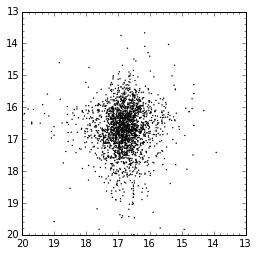

In [122]:
plt.figure(figsize=(4,4))
plt.scatter(both.V_mean, both.v, s=2, edgecolor="None", c='k')
plt.xlim(20,13)
plt.ylim(20,13)
plt.minorticks_on()
plt.show()

### Just match OGLE and MACHO

Redownload original samples for both
Match positionally
Plot mag vs mag and period vs period

Next: toward bulge, use macho sample do matching statistics and find out limiting magnitudes
Looking at macho period-luminosity: separate sequences, show where they end up in WISE color-mag diagrams
Vice-versa, take separations in WISE color-mag/color-color diagrams and color code them in macho period-luminosity diagrams. Want to show that there's definite structure between O-rich and C-rich objects in MACHO period-luminosity space

In [8]:
sql = "SELECT * FROM macho_ogle_match_alldata;"
match = pd.read_sql(sql, db)


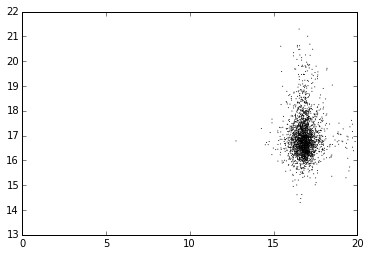

In [14]:
plt.scatter(match.V_mean, match.vmag, s=1, edgecolor="None", c='k')
plt.xlim(0,20)
plt.show()